In [1]:
import os, sys, pickle
%pylab inline
plt.style.use("default")
# Turn off top and right spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.figsize'] = (8, 3)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Preprocessing

In [2]:
data = pickle.load(open("data/striatum-data.p", "rb"))

In [3]:
trials         = data["trials_indices"]
neurons        = data["neurons"].values
spike_times    = data["spikes_times"]
trial_starts   = data["trials_start_times"]
trial_ends     = data["trials_end_times"]
trial_lengths  = trial_ends - trial_starts
earliest_spike = min([min(concatenate([neuron for neuron in trial])) for trial in spike_times])
latest_spike   = max([max(concatenate([neuron for neuron in trial])) for trial in spike_times])

In [4]:
spikes_dict = {itrial:{ineuron: spike_times[itrial][ineuron] for ineuron, neuron in enumerate(neurons)} for itrial, trial in enumerate(trials)}

Text(0, 0.5, 'Trial length (s)')

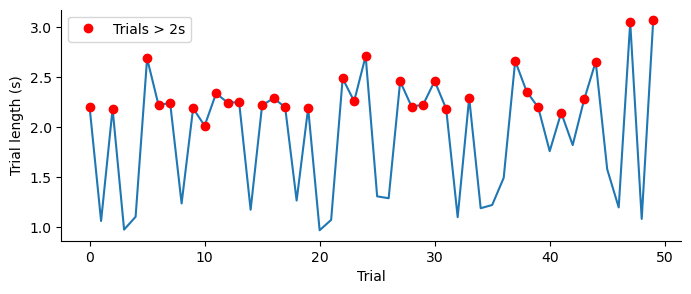

In [5]:
long_trial_length = 2
long_trials = where(trial_lengths > long_trial_length)[0]
plot(trial_lengths)
plot(long_trials, trial_lengths[long_trials], "ro", label = "Trials > 2s")
legend();
xlabel("Trial"); ylabel("Trial length (s)")

In [6]:
# Alternate the colors so adjacent neurons can be distinguished
neuron_colors = [cm.hsv(0.5*(i % 2) + 0.5*i/len(neurons)) for i in range(len(neurons))]

In [7]:
def plot_raster(spike_times, which_trials, which_neurons, trials_first = False, subtract_trial_start = False, t_min = earliest_spike - 0.25, t_max = latest_spike + 0.25,
                neuron_colors = neuron_colors,
                spike_gap = 0.1,
                trial_gap = 0.1,
                ylab_fontsize = 8,
                ):
    # Iterate through trials and neurons
    inner_loop = which_trials  if trials_first else which_neurons
    outer_loop = which_neurons if trials_first else which_trials
    iplt = 0
    h_spike = 1 - spike_gap
    h_trial = 1 - trial_gap
    labs = []
    for ind_out in outer_loop:
        for ind_in in inner_loop:
            neuron, trial = (ind_out, ind_in) if trials_first else (ind_in, ind_out)
            labs.append(f"{neuron}:{trial}")
            # Get spike times
            t_spikes    = spike_times[trial][neuron] - subtract_trial_start * trial_starts[trial]
            trial_start = trial_starts[trial]        - subtract_trial_start * trial_starts[trial]
            trial_end   = trial_ends[trial]          - subtract_trial_start * trial_starts[trial]
            # Plot the trial
            plt.fill_between([trial_start, trial_end], [iplt - h_trial/2, iplt - h_trial/2], [iplt + h_trial/2, iplt + h_trial/2], color="darkgray", alpha=0.3, edgecolor="black")
            # Plot spikes
            plt.plot([t_spikes, t_spikes], [(iplt-h_spike/2) + 0*t_spikes,(iplt+h_spike/2)+0*t_spikes], lw=1, color = neuron_colors[neuron])
            iplt += 1
    # Set the axis background color to black
    gca().set_facecolor('black')
    ylim(-1, iplt)
    gca().set_yticks(arange(iplt), labs, fontsize=ylab_fontsize)
    xlabel("Time (s)" if not subtract_trial_start else "Time from trial start (s)")
    ylabel("Neuron:trial")

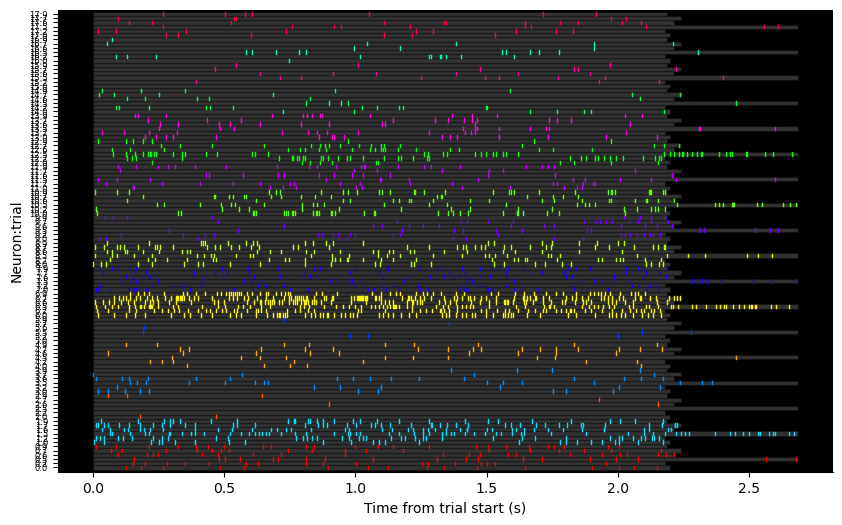

In [8]:
which_trials = long_trials[0:6]
figure(figsize=(10,1 * len(which_trials)))
plot_raster(spike_times, which_trials =which_trials, which_neurons = range(len(neurons)), trials_first = True, subtract_trial_start = True, spike_gap = 0.2, trial_gap = 0, ylab_fontsize = 6)

### Bin spike times

In [9]:
bin_res = 0.01
window_size = 0.1
t_min   =  -0.5
t_max   = 2
bins    = arange(t_min, t_max, bin_res)
binned_spikes = np.zeros((len(trials), len(neurons), len(bins)-1))
for itrial, trial in enumerate(trials):
    for ineuron, neuron in enumerate(neurons):
        for ibin in range(len(bins)-1):
            binned_spikes[itrial, ineuron, ibin] = sum((bins[ibin] <= spike_times[itrial][ineuron]) & (spike_times[itrial][ineuron] < bins[ibin]+window_size))

### Trial average

In [10]:
X = binned_spikes[long_trials].mean(axis=0) 
t = bins[:-1] + window_size/2

# Practical

Text(0.5, 0, 'Time bin')

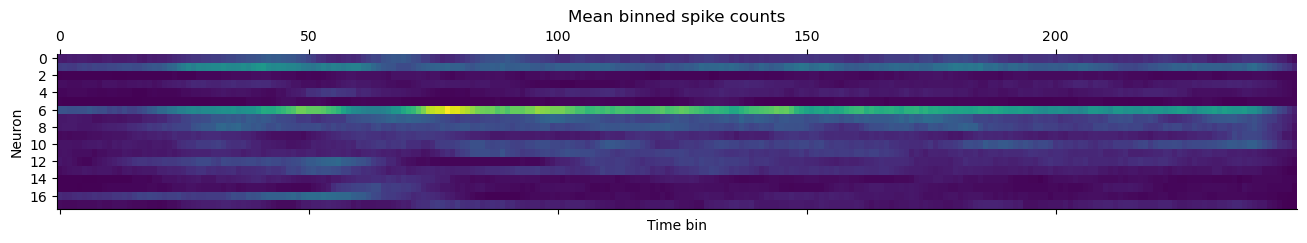

In [11]:
matshow(X); axis("auto")
title("Mean binned spike counts")
ylabel("Neuron")
xlabel("Time bin")

In [12]:
Xn = X / std(X,axis=1)[:, None]

(-0.5, 248.5, 17.5, -0.5)

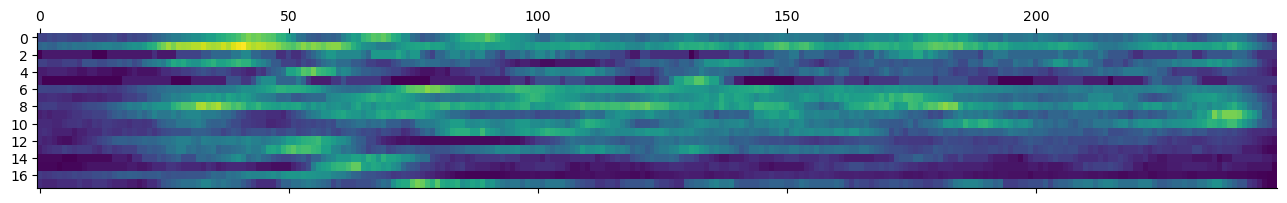

In [13]:
matshow(Xn); axis("auto")

# Coordinate Systems

## Plot some data

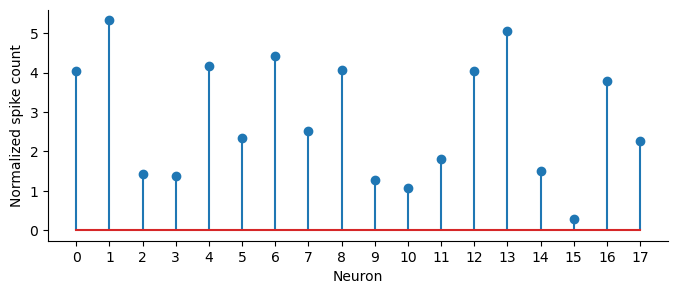

In [14]:
# Plot the data at bin 50
x = Xn[:, 50]
stem(x);
xlabel("Neuron"); ylabel("Normalized spike count");
gca().set_xticks(arange(len(neurons)));

## Generate the standard basis elements

In [15]:
n = len(x)
e = zeros((n,n))
for i in range(n):
    e[i,i] = 1

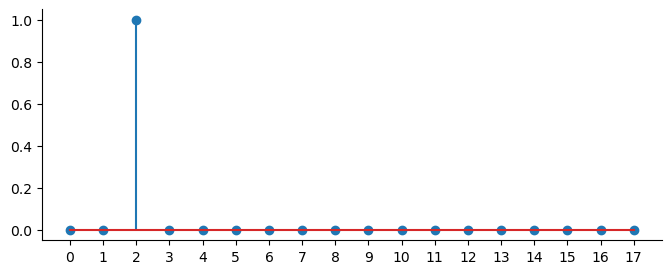

In [16]:
# Plot the third basis element
stem(e[2]);
gca().set_xticks(arange(len(neurons)));

## Data extraction as projection

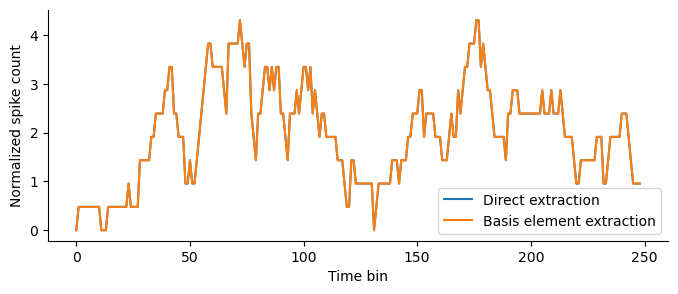

In [17]:
# Extract the data for the third neuron directly
x3 = Xn[2]
# Extract the data for the third neuron as a projection
x3b = e[2] @ Xn
# Overlay the two extractions
plot(x3,  label="Direct extraction")
plot(x3b, label="Basis element extraction")
xlabel("Time bin"); ylabel("Normalized spike count")
legend()

assert allclose(x3, x3b), "The two extraction methods are not the same"


### Reconstruct the data at bin 50 using the basis elements

In [19]:
x_rec = 0*x
for i in range(n):
    xi = e[i] @ x
    x_rec += xi * e[i]

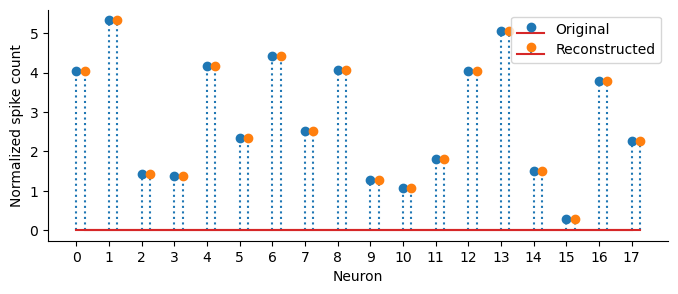

In [20]:
locs = arange(len(neurons))
stem(locs, x, "o:", label="Original")
# Shift the reconstructed data to the right so that it is visible
stem(locs + 0.25, x_rec, "o:", label="Reconstructed")
xlabel("Neuron"); ylabel("Normalized spike count")
gca().set_xticks(locs)
legend(fontsize=10)


# Variance and Covariance

### Compute the variance of the third neuron directly and manually

In [21]:
x3 = Xn[2]
v3 = var(x3)
m3 = x3.mean()
v3_manual = ((x3 - m3)**2).mean()

In [22]:
print(f"Direct variance: {v3}")
print(f"Manual variance: {v3_manual}")
# Check that the two methods are the same
assert allclose(v3, v3_manual), "The two methods of computing variance are not the same"

Direct variance: 1.0
Manual variance: 1.0


### Compute the neuron-neuron covariance matrix directly and manually

In [23]:
C = cov(Xn, bias=True)
assert C.shape == (n,n), "The covariance matrix is not the right shape"

In [24]:
C_manual = zeros((n,n))
for i in range(n):
    xi = Xn[i]
    xi_m = xi.mean()
    for j in range(n):
        xj = Xn[j]
        xj_m = xj.mean()

        C_manual[i,j] = ((xi - xi_m) * (xj - xj_m)).mean()        

In [25]:
assert allclose(C, C_manual), "The two methods of computing covariance are not the same"

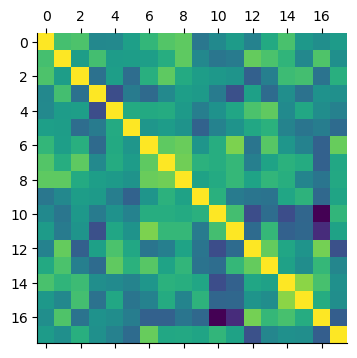

In [26]:
matshow(C)

### Compute the variance of the third neuron by accessing the covariance matrix directly, and by projection

In [27]:
v3_direct = C[2,2]

In [28]:
v3_proj   = e[2] @ C @ e[2]

In [29]:
print(f"Direct     variance: {v3_direct}")
print(f"Projection variance: {v3_proj}")
assert allclose(v3_direct, v3_proj), "The two methods of computing variance are not the same"

Direct     variance: 1.0000000000000022
Projection variance: 1.0000000000000022


### Compute the covariance of the third and fourth  neurons manually, by indexing the covariance matrix, and by projection

In [30]:
x3 = e[2] @ Xn
x4 = e[3] @ Xn
x3_m = x3.mean()
x4_m = x4.mean()

In [31]:
cov34_direct = C[2,3]

In [32]:
cov34_manual = ((x3 - x3_m) * (x4 - x4_m)).mean()

In [33]:
cov34_proj = e[2] @ C @ e[3]

In [34]:
print(f"Direct     covariance: {cov34_direct}")
print(f"Manual     covariance: {cov34_manual}")
print(f"Projection covariance: {cov34_proj}")
assert allclose([cov34_direct, cov34_manual, cov34_proj], [cov34_direct]*3), "The three methods of computing covariance are not the same"

Direct     covariance: -0.040190258200167556
Manual     covariance: -0.04019025820016741
Projection covariance: -0.040190258200167556


# Pseudo-neurons

Remember that real neurons correspond to the standard coordinates.
The first neuron corresponds to e[0], the second to e[1], and so on.
We can form combinations of these into pseudo-neurons.

### Create a pseudo-neuron that is the average of the first and second neurons

In [35]:
u = 0.5 * e[0] + 0.5 * e[1]
u /= sqrt((u**2).sum())
assert allclose(sum(u**2), 1), "The pseudo-neuron is not normalized"

### Get the activity of the pseudo-neuron by projection, and plot it along with the activity of the first and second neurons

In [36]:
y = u @ Xn

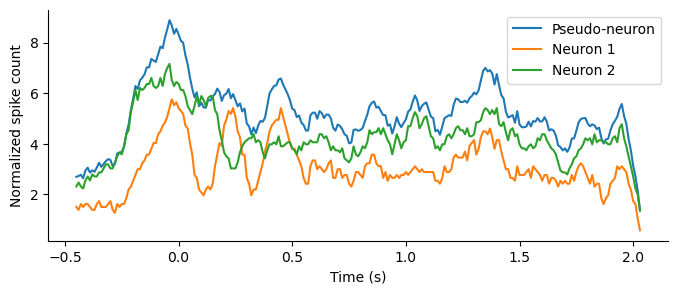

In [37]:
plot(t, y, label="Pseudo-neuron")
plot(t, Xn[0], label="Neuron 1")
plot(t, Xn[1], label="Neuron 2")
xlabel("Time (s)"); ylabel("Normalized spike count"); legend(fontsize=10)

### Compute the mean of the pseudo neuron directly, and by projecting the population mean

In [38]:
ym_direct = sum(y) / len(y)

In [39]:
ym_proj = u @ Xn.mean(axis=1)

In [40]:
print(f"Direct     mean: {ym_direct}")
print(f"Projection mean: {ym_proj}")
assert allclose(ym_direct, ym_proj), "The two methods of computing the mean are not the same"

Direct     mean: 5.183582817293332
Projection mean: 5.183582817293332


### Compute the variance of the pseudo neuron directly, and by projecting the population covariance

In [41]:
yv_direct = var(y) 

In [42]:
yv_proj = u @ C @ u

In [43]:
print(f"Direct     variance: {yv_direct}")
print(f"Projection variance: {yv_proj}")
assert allclose(yv_direct, yv_proj), "The two methods of computing the variance are not the same"

Direct     variance: 1.507179779594782
Projection variance: 1.5071797795947819


# Maximum variance directions

### Create a smaller dataset consisting of the first two neurons

Text(0, 0.5, 'Neuron 2')

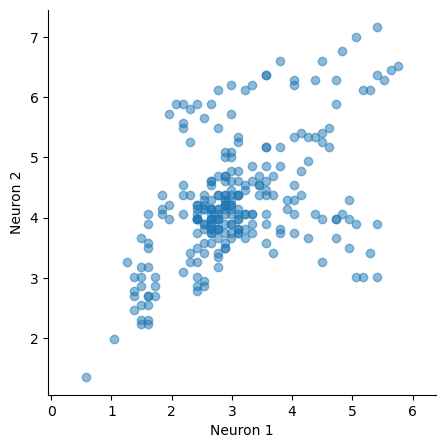

In [61]:
X12 = Xn[:2]
figure(figsize=(5,5))
scatter(X12[0], X12[1], alpha=0.5); axis("equal")
xlabel("Neuron 1"); ylabel("Neuron 2")

### Compute the variance for a pseudo-neuron whose direction is pi/6 radians

In [62]:
C12 = cov(X12, bias=True)

In [76]:
u = array([cos(pi/6), sin(pi/6)])
v = u @ C12 @ u
print(v, var(u @ X12))

1.439230573414874 1.4392305734148743


### Plot a line going through the mean of the data, extending one standard deviation along the direction of the pseudo-neuron

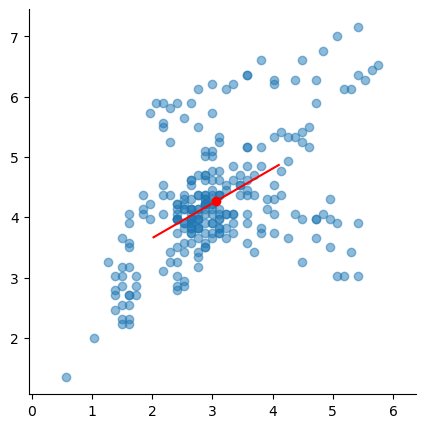

In [78]:
figure(figsize=(5,5))
scatter(X12[0], X12[1], c="C0", alpha=0.5); axis("equal")
s = sqrt(v)
m = X12.mean(axis=1)
plot(m[0], m[1], 'ro')
plot([m[0] - s*u[0], m[0] + s*u[0]], [m[1] - s*u[1], m[1] + s*u[1]], 'r');

### Compute the variance at each direction along the circle by sweeping angles from 0 to 2pi

In [66]:
C12 = cov(X12, bias=True)

In [102]:
th = linspace(0, 2*pi, 1000)
v = zeros_like(th)
for i in range(len(th)):
    u = array([cos(th[i]), sin(th[i])])
    v[i] = u @ C12 @ u    

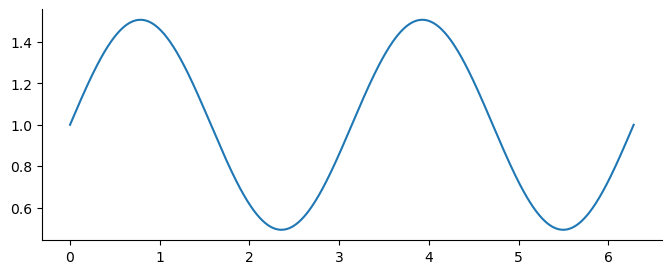

In [103]:
plot(th, v)

### Use SVD to find the maximum variance directions and the variances

In [113]:
# Compute the covariance matrix
C12 = cov(X12)
U12,s12,U12t = svd(C12)
assert allclose(U12, U12t.T)
print(f"Maximum and minimum variances:", s12)

Maximum and minimum variances: [1.51325712 0.4948074 ]


### Plot the points corresponding to one standard deviation from the mean along each direction and add lines for the maximum and minimum directions computed by SVD on the covariance matrix

(array([6.38915792]), array([6.38915792]))

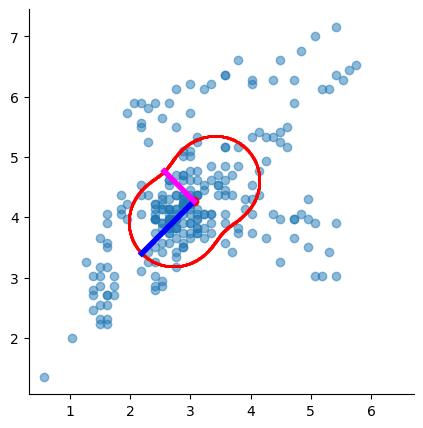

In [118]:
# Plot the data
figure(figsize=(5,5))
scatter(X12[0], X12[1], c="C0", alpha=0.5); axis("equal")
# Plot a point at the mean
m = X12.mean(axis=1)
plot(m[0], m[1], 'ro')
# Plot the standard deviation along each direction
for th_i, v_i in zip(th, v):
    u = array([cos(th_i), sin(th_i)])
    s = sqrt(v_i)
    plot([m[0], m[0] + s*u[0]], [m[1], m[1] + s*u[1]], 'r.', markersize=2)

plot([m[0], m[0] + U12[0,0] * sqrt(s12[0])], [m[1], m[1] + U12[1,0] * sqrt(s12[0])], "blue", lw=4)
plot([m[0], m[0] + U12[0,1] * sqrt(s12[1])], [m[1], m[1] + U12[1,1] * sqrt(s12[1])], "magenta", lw=4)
axis("square")
diff(xlim()), diff(ylim())

# PCA

In [89]:
Xn_mean = Xn.mean(axis=1)
Xms= Xn - Xn_mean[:, np.newaxis]

In [91]:
U,s,Vt = np.linalg.svd(Xms, full_matrices=False)
print(U.shape, s.shape, Vt.shape)

(18, 18) (18,) (18, 249)


Text(0, 0.5, 'Cumulative explained variance')

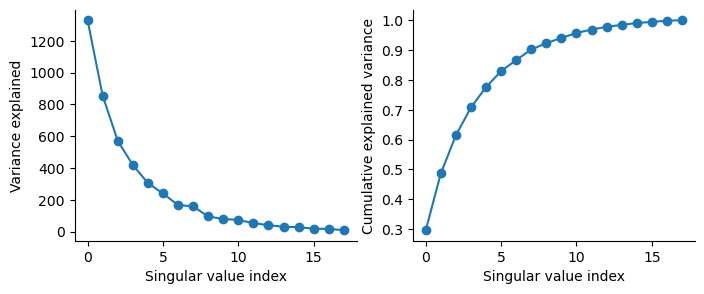

In [92]:
subplot(121); plot(s**2, "o-"); xlabel("Singular value index"); ylabel("Variance explained")
subplot(122); plot((s**2).cumsum()/(s**2).sum(), "o-"); xlabel("Singular value index"); ylabel("Cumulative explained variance")


## Plot trajectories

In [93]:
Y = diag(s[:2]) @ Vt[:2,:]
t = bins[:-1]

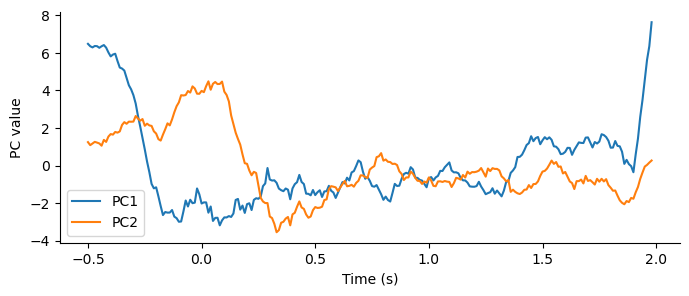

In [94]:
plot(t, Y[0], label="PC1")
plot(t,  Y[1], label="PC2")
xlabel("Time (s)")
ylabel("PC value")
legend()


Text(0, 0.5, 'PC2')

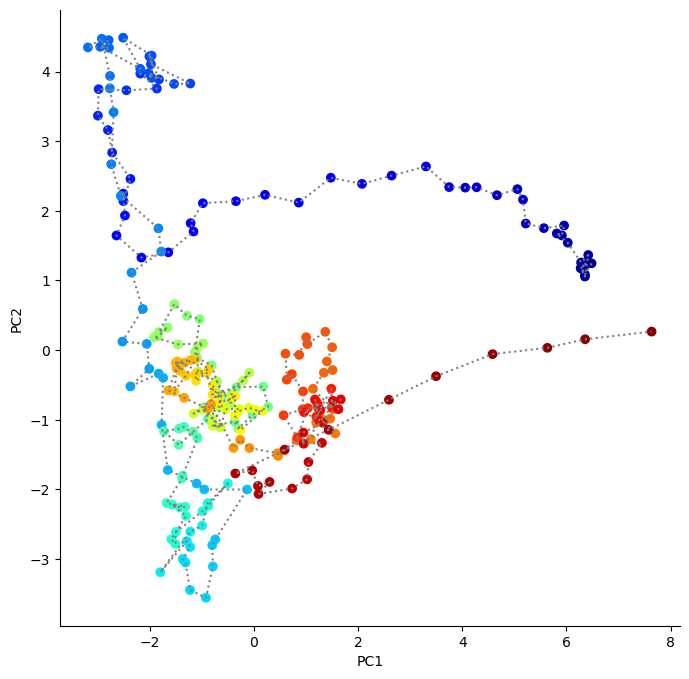

In [95]:
figure(figsize=(8, 8))
cmap = cm.jet
plot(Y[0], Y[1], ":", color="gray")
scatter(Y[0], Y[1], c=[cmap(i/float(len(Y[0]))) for i in range(len(Y[0]))])
xlabel("PC1")
ylabel("PC2")

## Reconstruction

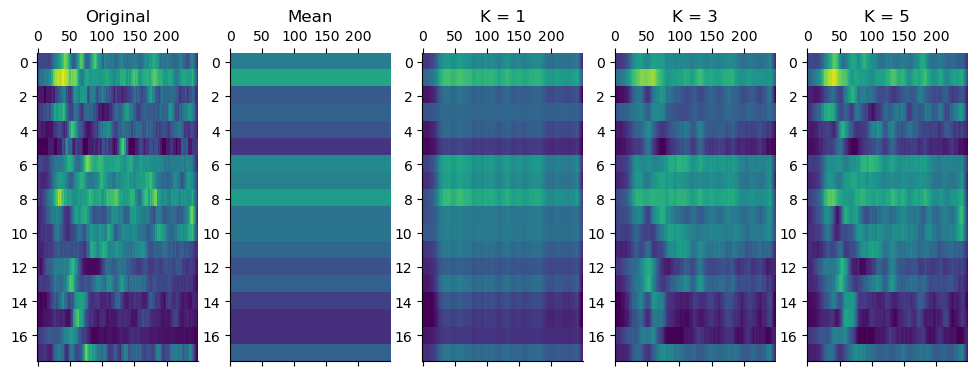

In [99]:
n_cmps = [1,3,5]
figure(figsize=(12, 4))
subplot(151); matshow(Xn, aspect="auto", fignum=False); title("Original")
# Get vmin and vmax for all plots
vmin, vmax = gci().get_clim()
subplot(152); matshow(outer(Xn_mean, ones(len(bins))), aspect="auto", fignum=False, vmin=vmin, vmax=vmax);
title("Mean")
for i, n_cmp in enumerate(n_cmps):
    Xrec = (U[:,:n_cmp] @ np.diag(s[:n_cmp]) @ Vt[:n_cmp,:]) + Xn_mean[:, np.newaxis]
    subplot(1, 5, i+3); matshow(Xrec, aspect="auto", fignum=False, vmin=vmin, vmax=vmax); title(f"K = {n_cmp}")

